# RIC and RBDS gait event detection

Reginaldo K Fukuchi reginaldo.fukuchi@ufabc.edu.br

This NB implements the "gait_steps.m" Sean Osis method to detect gait events.

In [11]:
# Prepare environment
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import data
pathname = r'../data'

### Supporting functions

In [24]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    import scipy.io as spio
    
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

## Import data
Use RIC data to test the method first

In [32]:
figshare_dir = r'C:\Users\Reginaldo\OneDrive - University of Calgary\data\Figshare_SciData\new_unzip'
data_dir = r'../data'

## Compare output angles
between gait_kinematics.m and the ones I calculated

In [37]:
# Import mat file of joint angles calculated using gait_kinematics.m function
fn_mat_r = os.path.join(figshare_dir,'201225','20140515T133244_r.mat')
mat2dict_r = loadmat(fn_mat_r)
# Right ankle angle
r_ankle_ang_sean = np.array(mat2dict_r['r_angles']['R_ankle'])
r_ankle_ang_sean.shape

(5000, 3)

In [38]:
# Import angles calculated by RIC_RBDS_study.ipynb
r_ankle_ang_regi = pd.read_csv(os.path.join(data_dir, 'ankle_ang.csv'), sep='\t')
r_ankle_ang_regi.head()

,ankle_X,ankle_Y,ankle_Z
NaN,67.344521,-35.196960,7.313946
NaN,68.481197,-37.363098,7.861039
NaN,69.703159,-39.870894,8.492013
NaN,71.027040,-42.801240,9.244145
NaN,72.504945,-46.259436,10.187319


### Plot angles for comparison

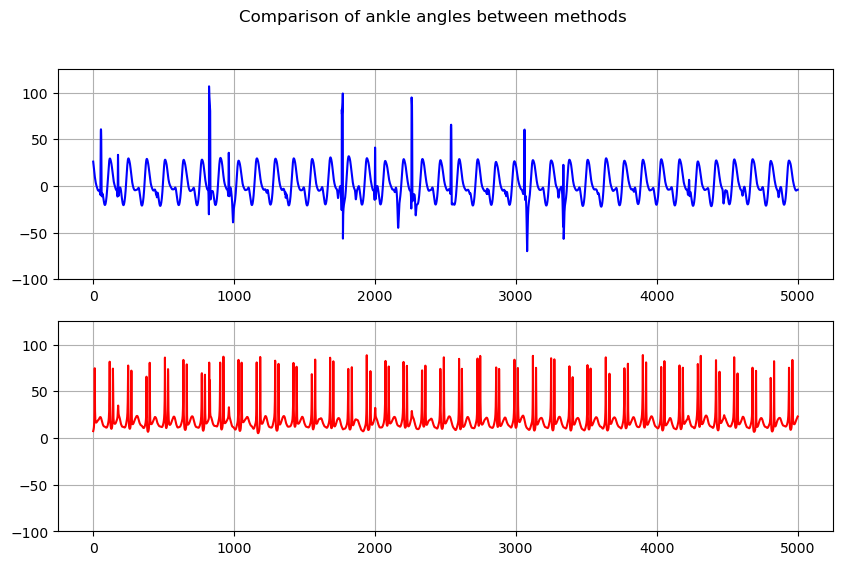

In [41]:
fig, axs = plt.subplots(2, figsize=(10,6))
fig.suptitle('Comparison of ankle angles between methods')
axs[0].plot(r_ankle_ang_sean[:,2], 'b', label='Sean')
axs[0].set_ylim([-100,125])
axs[0].grid('on')
axs[1].plot(r_ankle_ang_regi.values[:,2], 'r', label='Regi')
axs[1].set_ylim([-100,125])
axs[1].grid('on')
plt.show()

In [4]:
import json

In [16]:
fn_json=os.path.join(figshare_dir, '201225', '20140515T133244.json')

In [6]:
with open(fn_json, 'r') as f:
    data_RIC = json.load(f)

In [10]:
data_RIC['running'].keys()

dict_keys(['pelvis_1', 'pelvis_2', 'pelvis_3', 'pelvis_4', 'L_thigh_1', 'L_thigh_2', 'L_thigh_3', 'L_thigh_4', 'R_thigh_1', 'R_thigh_2', 'R_thigh_3', 'R_thigh_4', 'L_shank_1', 'L_shank_2', 'L_shank_3', 'L_shank_4', 'R_shank_1', 'R_shank_2', 'R_shank_3', 'R_shank_4', 'L_foot_1', 'L_foot_2', 'L_foot_3', 'L_foot_4', 'R_foot_1', 'R_foot_2', 'R_foot_3', 'R_foot_4'])

In [7]:
fname_out_S = os.path.join(pathname, 'RIC_static.csv')
fname_out_R = os.path.join(pathname, 'RIC_run.csv')

In [ ]:
df_S = pd.read_csv(fname_out_S, delimiter=',', usecols=range(1,115))

In [ ]:
df_R = pd.read_csv(fname_out_R, delimiter=',', usecols=range(1,85))

In [ ]:
heels = df_S[['L_foot_1_X', 'L_foot_1_Y', 'L_foot_1_Z',
              'L_foot_2_X', 'L_foot_2_Y', 'L_foot_2_Z',
              'L_foot_3_X', 'L_foot_3_Y', 'L_foot_3_Z']].values.flatten()

Find the lowest of the two heel markers

In [ ]:
heels = df_S[['R_foot_1_Y', 'R_foot_2_Y']].values.flatten()
# Find the lowest marker
if heels.argmin()==0:
    heelB = df_R[['R_foot_1_X', 'R_foot_1_Y', 'R_foot_1_Z']].values
else:
    heelB = df_R[['R_foot_2_X', 'R_foot_2_Y', 'R_foot_2_Z']].values

Calculate velocity and cadence

In [ ]:
from detecta import detect_peaks

In [ ]:
heelV  = np.diff(heelB[:,0])
iHeel_p= detect_peaks(heelV, mpd=np.round(0.5*data_RIC['hz_r']), 
                    mph=0, show=False)
Heel_p = heelV[inds]

In [ ]:
vel    = data_RIC['hz_r']*np.median(Heel_p)/1000; # gait speed
stRate = 60/(np.median(np.diff(iHeel_p))/data_RIC['hz_r']); # cadence
print('Gait velocity is '+str(vel.round(1))+' m/s')
print('Stride rate is '+str(stRate.round(1))+' strides/min')

In [ ]:
speedoutput = vel

### Identify gait type using a trained LDA classifier

This will be more robust for shuffle-runners, older adults and speed walkers.  
gaitClass represents an LDA object which has been trained on 839 test sets of walking and running, and validated on ~2000 sets of walking and running.

In [ ]:
testSet = [vel stRate];
import classreg.learning.classif.CompactClassificationDiscriminant
load('gaitClass.mat','gaitClass')

label = predict(gaitClass,testSet);
# label returned as cell
label = label{1};

#### RIC

In [ ]:
RIC_mkr_S_lbl = df_S.columns.tolist()
RIC_mkr_S_lbl = [mkr[:-2] for mkr in RIC_mkr_S_lbl]
RIC_mkr_S_lbl = f7(RIC_mkr_S_lbl)

In [ ]:
# Average marker position
mkr_S = df_S.values.flatten()
# Marker labels list
mkr_S_lbl = RIC_mkr_S_lbl

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d',  facecolor='white')
ax.view_init(15, 20)


ax.scatter(mkr_S[2:-1:3], mkr_S[0:-3:3], mkr_S[1:-2:3],  
           c='r', s=30, depthshade=False)
for m, mkr_lbl in enumerate(mkr_S_lbl):
    ax.text(mkr_S[3*m+2], mkr_S[3*m], mkr_S[3*m+1], mkr_lbl)

ax.set_xlabel('\n' + 'Z [m]', linespacing=2)
ax.set_ylabel('\n' + 'X [m]', linespacing=2)
ax.set_zlabel('\n' + 'Y [m]', linespacing=2)
#ax.invert_yaxis()
# square plot
ax.set_aspect('equal', adjustable='box')
ax.set_xlim3d([np.nanmin(mkr_S[2::3])-.4, np.nanmax(mkr_S[2::3])+.4])
ax.set_ylim3d([np.nanmin(mkr_S[0::3])-.4, np.nanmax(mkr_S[0::3])+.4])
ax.set_zlim3d([np.nanmin(mkr_S[1::3]), np.nanmax(mkr_S[1::3])])
plt.show()

### Calculate hip joint center
* https://c-motion.com/v3dwiki/index.php?title=Coda_Pelvis
* RHJC=(-0.19*ASIS_Distance,-0.3*ASIS_Distance,0.36*ASIS_Distance)

In [ ]:
RASI = df_s[['RASI_X','RASI_Y','RASI_Z']].values.mean(axis=0)
LASI = df_s[['LASI_X','LASI_Y','LASI_Z']].values.mean(axis=0)
ASIS_distance_S = np.linalg.norm(RASI-LASI)
rhjc_S = np.array([RASI[0]-0.19*ASIS_distance_S, RASI[1]-0.3*ASIS_distance_S, 
                   RASI[2]-0.36*ASIS_distance_S])

In [ ]:
# Shank reference system
rkjc_S = (df_s[['RKNL_X','RKNL_Y','RKNL_Z']].values.mean(axis=0)+
        df_s[['RKNM_X','RKNM_Y','RKNM_Z']].values.mean(axis=0))/2
rajc_S = (df_s[['RMAL_X','RMAL_Y','RMAL_Z']].values.mean(axis=0)+
        df_s[['RMAM_X','RMAM_Y','RMAM_Z']].values.mean(axis=0))/2

v2 = rkjc_S - rajc_S
v1 = np.cross(v2, df_s[['RMAL_X','RMAL_Y','RMAL_Z']].values.mean(axis=0) - rajc_S)
v3 = np.cross(v1, v2)

print('Versors of the shank:')
v1 = v1/np.linalg.norm(v1)
print('v1 =', v1)
v2 = v2/np.linalg.norm(v2)
print('v2 =', v2)
v3 = v3/np.linalg.norm(v3)
print('v3 =', v3)

bs = np.array([v1, v2, v3])

In [ ]:
# Thigh reference system
v2t = rhjc_S-rkjc_S
v1t = np.cross(v2t,df_s[['RKNL_X','RKNL_Y','RKNL_Z']].values.mean(axis=0)-rkjc_S)
v3t = np.cross(v2t,v1t)

print('Versors of the thigh:')
v1t = v1t/np.linalg.norm(v1t)
print('v1t =', v1t)
v2t = v2t/np.linalg.norm(v2t)
print('v2t =', v2t)
v3t = v3t/np.linalg.norm(v3t)
print('v3t =', v3t)

bt = np.array([v1t,v2t,v3t])

## Calculate knee joint angle according to Grood & Suntay (1983)

In [ ]:
def kneeang(proxrf, distalrf):
    """
    Calculate 3D knee joint angle in degrees
    """
    angk = np.empty(shape=(3,))
    proxrf = bt
    distalrf = bs
    yk = bs[1,:];
    zk = bt[2,:];
    fk = np.cross(yk,zk); #floating axis
    fk = fk/np.linalg.norm(fk)
    bk =np.array([fk, yk, zk]);
    zs_t = bs[2,:];
    
    # knee angle
    angk[0] = -(np.pi/2 - np.arccos(np.sum(bt[1]*fk)))*180/np.pi # Flexion/Extension
    angk[1] = (-np.pi/2 - np.arccos(np.sum(yk*bt[2])))*180/np.pi + 180 #Abduction/aduction
    angk[2] = (np.pi/2 - np.arccos(np.sum(zs_t*fk)))*180/np.pi #Internal/external rotation
    
    return angk

# Running data

In [ ]:
df_r = pd.read_csv(fname_out_R, delimiter=',', index_col='Time')

In [ ]:
df_r.head()

# Gait event detection [https://c-motion.com/v3dwiki/index.php?title=Events:Example_6]



* Zeni JA, Richards JG, Higginson JS (2008) Two simple methods for determining gait events during treadmill and overground walking using kinematic data. Gait & Posture 27, 710-714

### Create signals necessary to replicate the methods

# Transform markers into pelvic coordinate system

In [ ]:
import sys
sys.path.insert(1, r'./../functions')
from svdt import svdt

## Handle lack of RASI and LASI markers in RIC protocol; and RTOE in RBDS protocol

In [ ]:
RPSIr = df_r[['RPSI_X','RPSI_Y','RPSI_Z']].values
LPSIr = df_r[['LPSI_X','LPSI_Y','LPSI_Z']].values
if db_name=='RIC':
    # Pelvic segment
    Ap = df_s[['RPSI_X','RPSI_Y','RPSI_Z','LPSI_X','LPSI_Y','LPSI_Z',
               'VSAC_X','VSAC_Y','VSAC_Z']].values.mean(axis=0)
    Bp = df_r[['RPSI_X','RPSI_Y','RPSI_Z','LPSI_X','LPSI_Y','LPSI_Z',
               'VSAC_X','VSAC_Y','VSAC_Z']].values
    
    # Reconstructed markers based on technical clusters
    Rp, Lp, RMSEp = svdt(Ap, Bp)    
    RASIs = df_s[['RASI_X','RASI_Y','RASI_Z']].values.mean(axis=0)
    LASIs = df_s[['LASI_X','LASI_Y','LASI_Z']].values.mean(axis=0)
    RASIr = np.dot(Rp,RASIs)  + Lp
    LASIr = np.dot(Rp,LASIs)  + Lp
    VSACr = df_r[['VSAC_X','VSAC_Y','VSAC_Z']].values
    RTOEr = df_r[['RTOE_X','RTOE_Y','RTOE_Z']].values
else:
    RASIr = df_r[['RASI_X','RASI_Y','RASI_Z']].values
    LASIr = df_r[['LASI_X','LASI_Y','LASI_Z']].values
    VSACr  = (RPSIr+LPSIr)/2
    RTOEr = df_r[['RMH1_X','RMH1_Y','RMH1_Z']].values

In [ ]:
db_name

In [ ]:
RHEPr = df_r[['RHEP_X','RHEP_Y','RHEP_Z']].values
RHEDr = df_r[['RHED_X','RHED_Y','RHED_Z']].values

In [ ]:
def pelvisCS(RASIr, LASIr, VSACr):
    # Pelvic reference system
    midASIS = (RASIr+LASIr)/2
    
    v2p = np.cross(RASIr-VSACr,LASIr-VSACr)
    v3p = RASIr-midASIS
    v1p = np.cross(v2p,v3p)

    v1p = v1p/np.linalg.norm(v1p)
    v2p = v2p/np.linalg.norm(v2p)
    v3p = v3p/np.linalg.norm(v3p)

    bp = np.array([v1p,v2p,v3p])
    
    return bp

In [ ]:
LAB = np.array([[1,0,0],[0,1,0],[0,0,1]])

In [ ]:
RHEDr_pelvis = np.empty(shape=RHEDr.shape)
RTOEr_pelvis = np.empty(shape=RTOEr.shape)
bp = np.empty(shape=(RTOEr.shape[0],9))
for i in range(RASIr.shape[0]):
    pp = pelvisCS(RASIr[i,:], LASIr[i,:], VSACr[i,:])
    #pp = midASIS+pp
    bp[i,:] = pp.reshape((9,))
    #Rp, Lp, RMSEp = svdt(LAB, bp)

In [ ]:
Rp, Lp, RMSEp = svdt(LAB, bp)

In [ ]:
for ix in range(RHEDr.shape[0]):
    RHEDr_pelvis[ix,:] = np.dot(Rp[ix,:,:],RHEDr[ix,:]) + Lp[ix,:]
    RTOEr_pelvis[ix,:] = np.dot(Rp[ix,:,:],RTOEr[ix,:]) + Lp[ix,:]

In [ ]:
from detecta import detect_peaks

In [ ]:
iTD = detect_peaks(RHEDr_pelvis[:,0], mph=None, mpd=70, valley=False, show=False)
iTD

In [ ]:
iTO = detect_peaks(RTOEr_pelvis[:,0], mph=None, mpd=70, valley=True, show=False)
iTO

# TRIMM DATA AND CHECAR ANGLES

### STATIC

In [ ]:
fname_c3d = os.path.join(pathname,'RBDS001static.c3d')
c = c3d(fname_c3d)

In [ ]:
point_data = c['data']['points']
points_residuals = c['data']['meta_points']['residuals']
analog_data = c['data']['analogs']

In [ ]:
mkr_S_labels_RBDS = c['parameters']['POINT']['LABELS']['value']
print(mkr_S_labels_RBDS)

In [ ]:
mkr_S_labels_RBDSm=['LMAL', 'LMAM', 'LASI', 'LGTR', 'LHED', 'LHEL', 'LHEP', 
                    'LFIB', 'LIC', 'LKNL', 'LKNM', 'LMH1', 'LTOE', 'LMH5', 'LPSI', 'LSBL', 
                    'LSBM', 'LSTL', 'LSTM', 'LTBL', 'LTBM', 
                    'LTTL', 'LTTM', 'LTUB', 'RMAL', 'RMAM', 'RASI', 'RGTR', 'RHED', 
                    'RHEL', 'RHEP', 'RFIB', 'RIC', 'RKNL', 'RKNM', 'RMH1', 'RTOE', 'RMH5', 'RPSI', 
                    'RSBL', 'RSBM', 'RSTL', 'RSTM', 'RTBL', 
                    'RTBM', 'RTTL', 'RTTM', 'RTUB']

In [ ]:
mkr_S_data_RBDS = np.empty(shape=(point_data.shape[2],3*len(mkr_S_labels_RBDSm)))
for m, marker in enumerate(mkr_S_labels_RBDSm):
    mkr_S_data_RBDS[:,3*m:3*m+3] = point_data[:3, m, :].T

In [ ]:
xyz = list('XYZ')*len(mkr_S_labels_RBDSm)
mkr_S_labels_RBDS_2 = [ele for ele in mkr_S_labels_RBDSm for i in range(3)]
mkr_S_labels_RBDS_3 = [mkr_S_labels_RBDS_2[i]+'_'+xyz[i] for i in range(len(xyz))]

In [ ]:
df_S_RBDS = pd.DataFrame(data=mkr_S_data_RBDS, columns=mkr_S_labels_RBDS_3)

In [ ]:
duration  = int(c['parameters']['POINT']['RATE']['value'][0])/point_data.shape[2]
timeStamps= np.linspace(0, duration, mkr_S_data_RBDS.shape[0])

In [ ]:
df_S_RBDS['Time'] = timeStamps
df_S_RBDS.set_index('Time', inplace=True)
df_S_RBDS.index.name = 'Time'

In [ ]:
df_S_RBDS.head()

In [ ]:
ids

# PENDING
* Find who is who. 
Find the subjects in Figshare RBDSinfo.txt with the corresponding ID in RBA spreadsheet

# Another method of Gait event detection [https://pubmed.ncbi.nlm.nih.gov/27814970/]

The touchdown window started when the anterior-posterior velocity of the Heel first dropped below 1.5 m/s and ended at the next minima in vertical Heel position. The toe-off window started 100 ms after touchdown, and ended when the vertical Toe position either exceeded 0.1 m or reached a maximum (Fig. 1b). Notably, these cut-off values were able to successfully define TD and TO windows across the full range of ground contact times and, by implication, running speeds in this study.

To conclude, when estimating GCEs during running in the absence of a force platform, an algorithm that uses the first occurring of the vertical acceleration peaks of the Heel and Met to identify touchdown and the vertical jerk peak of the Toe to identify
toe-off is recommended. This algorithm requires an initial windowing step to identify reduced time windows containing touchdown and toe-off.

* Handsaker, J. C., Forrester, S. E., Folland, J. P., Black, M. I., & Allen, S. J. (2016). A kinematic algorithm to identify gait events during running at different speeds and with different footstrike types. Journal of biomechanics, 49(16), 4128–4133.

### Create signals necessary to replicate the methods Handsaker et al. (2016)

In [ ]:
RHEPr = df_R_RICm[['RHEP_X','RHEP_Y','RHEP_Z']].values/1000
RHEDr = df_R_RICm[['RHED_X','RHED_Y','RHED_Z']].values/1000
RTOEr = df_R_RICm[['RTOE_X','RTOE_Y','RTOE_Z']].values/1000

In [ ]:
from scipy.signal import butter, filtfilt

In [ ]:
RHEDr_f = np.empty(shape=(RHEDr.shape))
RTOEr_f = np.empty(shape=(RTOEr.shape))
# Butterworth filter
freq = data['out']['hz_r']
b, a = butter(2, (10/(freq/2)))

for i in range(3):
    RHEDr_f[:,i] = filtfilt(b, a, RHEDr[:,i])
    RTOEr_f[:,i] = filtfilt(b, a, RTOEr[:,i])

In [ ]:
RHEDr=RHEDr_f
RTOEr=RTOEr_f

In [ ]:
# Calculating velocity and acceleration
time = df_R_RIC.index.values
dt = np.mean(np.diff(time))
# Velocity
# RHED
RHEDr_vel_X = (RHEDr[2:,0]-RHEDr[:-2,0])/(2*dt)
RHEDr_vel_X = np.hstack((RHEDr[1,0]-RHEDr[0,0], RHEDr_vel_X, RHEDr[-2,0]-RHEDr[-1,0]))
RHEDr_vel_Y = (RHEDr[2:,1]-RHEDr[:-2,1])/(2*dt)
RHEDr_vel_Y = np.hstack((RHEDr[1,1]-RHEDr[0,1], RHEDr_vel_Y, RHEDr[-2,1]-RHEDr[-1,1]))
# RTOE
RTOEr_vel_Y = (RTOEr[2:,1]-RTOEr[:-2,1])/(2*dt)
RTOEr_vel_Y = np.hstack((RTOEr[1,1]-RTOEr[0,1], RTOEr_vel_Y, RTOEr[-2,1]-RTOEr[-1,1]))

# Acceleration
RHEDr_acc_Y = (RHEDr_vel_Y[2:]-RHEDr_vel_Y[:-2])/(2*dt)
RHEDr_acc_Y = np.hstack((RHEDr_vel_Y[1]-RHEDr_vel_Y[0], RHEDr_acc_Y, RHEDr_vel_Y[-2]-RHEDr_vel_Y[-1]))
# RTOE
RTOEr_acc_Y = (RTOEr_vel_Y[2:]-RTOEr_vel_Y[:-2])/(2*dt)
RTOEr_acc_Y = np.hstack((RTOEr_vel_Y[1]-RTOEr_vel_Y[0], RTOEr_acc_Y, RTOEr_vel_Y[-2]-RTOEr_vel_Y[-1]))

# Jerk
RTOEr_jkr_Y = (RTOEr_acc_Y[2:]-RTOEr_acc_Y[:-2])/(2*dt)
RTOEr_jkr_Y = np.hstack((RTOEr_acc_Y[1]-RTOEr_acc_Y[0], RTOEr_jkr_Y, RTOEr_acc_Y[-2]-RTOEr_acc_Y[-1]))

In [ ]:
from detecta import detect_onset
from detecta import detect_peaks

## Touch-down determination

In [ ]:
# Detect event where the RHED AP velocity signal is below threshold 1.5 m/s
iRHED_AP_VEL = detect_onset(-RHEDr_vel_X, 1.5, n_above=10, n_below=0, show=False)

In [ ]:
TD_window_1 = iRHED_AP_VEL[:,0]

In [ ]:
# Detect min vertical RHED position
TD_window_2 = detect_peaks(RHEDr[:,1], mph=None, mpd=70, valley=True, show=False)

In [ ]:
# Detect touch-down
iTD = np.empty(shape=(TD_window_2.shape[0]), dtype=np.int64)
for ip in range(TD_window_2.shape[0]):
    ind_p = detect_peaks(RHEDr_acc_Y[TD_window_1[0]:TD_window_2[0]], 
                                     mph=None, mpd=20, valley=False, show=False)
    iTD[ip] = TD_window_1[ip] + ind_p

In [ ]:
iTD

## Toe-off determination
The toe-off window started 100 ms after touchdown, and ended when the vertical Toe position either exceeded 0.1 m or reached a maximum (Fig. 1b). 

In [ ]:
time[iTD[0]] + 0.1

In [ ]:
TO_window_1 = (np.abs(time - (time[iTD[0]] + 0.1))).argmin()
TO_window_1

# Animation to understand

In [ ]:
# Detect touchdown
plt.figure(figsize=(10,6))
plt.plot(RHEDr[:,0],RHEDr[:,1],'b')
plt.grid('on')
plt.show()

# Make animation to understand the phenomenon

In [ ]:
from matplotlib.animation import FuncAnimation

In [ ]:
fig, ax = plt.subplots()
line, = ax.plot([], marker="o" , ls="-")     # A tuple unpacking to unpack the only plot
ax.set_xlim(-1, 0.5)
ax.set_ylim(0, 1)

def animate(frame_num):
    x = [RHEDr[:,0],RTOEr[:,0]]
    y = [RHEDr[:,1],RTOEr[:,1]]
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=100, interval=5)
plt.show()

In [ ]:
# Detect touchdown
plt.figure(figsize=(10,6))
plt.plot([RHEDr[iTD[0],0],RTOEr[iTD[0],0]], [RHEDr[iTD[0],1],RTOEr[iTD[0],1]],'bo-')
plt.plot([RHEDr[120,0],RTOEr[120,0]], [RHEDr[120,1],RTOEr[120,1]],'ro-')
plt.grid('on')
plt.show()

In [ ]:
# Detect event where the RTOE vertical position exceeded threshold of 0.1 meters
TO_window_2 = detect_onset(RTOEr[:,1], 0.1, n_above=10, n_below=0, show=True)

In [ ]:
TO_window_2[:,0]

In [ ]:
# Detect touchdown
plt.figure()
plt.plot(time[:1000], RTOEr[:1000,1])
plt.grid('on')
plt.show()

In [ ]:
TD_window_1

In [ ]:
iRHEDr_acc_Y_peak

In [ ]:
TD_window_2

In [ ]:
# Detect touchdown
plt.figure()
plt.plot(time[:1000], RHEDr_acc_Y[:1000])
plt.plot(time[int(TD_window_1[0]):int(TD_window_2[0])],
         RHEDr_acc_Y[int(TD_window_1[0]):int(TD_window_2[0])],'r')
plt.grid('on')
plt.show()

In [ ]:
TD_window_1 = list(TD_window_1)
TD_window_2 = list(TD_window_2)

In [ ]:
fig, axs = plt.subplots(4)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(time,RHEDr[:,1])
axs[0].grid('on')
axs[0].set_ylabel('RHED vertical position')
axs[1].plot(time[:-1],RHEDr_vel[:,0])
axs[1].grid('on')
axs[1].set_ylabel('RHED A-P velocity')
axs[2].plot(time,RTOEr[:,1])
axs[2].grid('on')
axs[2].set_ylabel('RTOE vertical position')
axs[3].plot(time[:-2],RHEDr_acc[:,1])
axs[3].grid('on')
axs[3].set_ylabel('RHED vertical acceleration')
plt.show()

In [ ]:
dx = [x(2,:)-x(1,:); (diff(x(1:end-1,:)) + diff(x(2:end,:)))/2; x(end,:)-x(end-1,:)];

In [ ]:
# forward difference algorithm:
vx, vy = np.diff(x)/dt,  np.diff(y)/dt
ax, ay = np.diff(vx)/dt, np.diff(vy)/dt
# central difference algorithm:
vx2, vy2 = (x[2:]-x[:-2])/(2*dt),     (y[2:]-y[:-2])/(2*dt)
ax2, ay2 = (vx2[2:]-vx2[:-2])/(2*dt), (vy2[2:]-vy2[:-2])/(2*dt)

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(time,RHEDr_acc_Y)
axs[0].grid('on')
axs[0].set_ylabel('RHED vertical acceleration')
axs[1].plot(time,RTOEr_jkr_Y)
axs[1].grid('on')
axs[1].set_ylabel('RTOE vertical jerk')
plt.show()

In [ ]:
fig, axs = plt.subplots(4)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(time,RHEDr[:,1])
axs[0].grid('on')
axs[0].set_ylabel('RHED vertical position')
axs[1].plot(time[:-1],RHEDr_vel[:,0])
axs[1].grid('on')
axs[1].set_ylabel('RHED A-P velocity')
axs[2].plot(time,RTOEr[:,1])
axs[2].grid('on')
axs[2].set_ylabel('RTOE vertical position')
axs[3].plot(time[:-2],RHEDr_acc[:,1])
axs[3].grid('on')
axs[3].set_ylabel('RHED vertical acceleration')
plt.show()

# <font color='red'>PENDING</font>
Now after filtering it appears the acc and jerk are reasonable
* FIND TOUCH-DOWN USING ACCELERATION WITHIN WINDOW
* FIND WINDOW FOR SEEKING TOEOFF
* FIND TOEOFF
* MAKE A FUNCTION
* USE EVENTS TO NORMALIZE ANGLES

In [ ]:
# Gait event detection [https://pubmed.ncbi.nlm.nih.gov/27814970/]

The touchdown window started when the anterior-posterior velocity of the Heel first dropped below 1.5 m/s and ended at the next minima in vertical Heel position. The toe-off window started 100 ms after touchdown, and ended when the vertical Toe position either exceeded 0.1 m or reached a maximum (Fig. 1b). Notably, these cut-off values were able to successfully define TD and TO windows across the full range of ground contact times and, by implication, running speeds in this study.

To conclude, when estimating GCEs during running in the absence of a force platform, an algorithm that uses the first occurring of the vertical acceleration peaks of the Heel and Met to identify touchdown and the vertical jerk peak of the Toe to identify
toe-off is recommended. This algorithm requires an initial windowing step to identify reduced time windows containing touchdown and toe-off.

* Handsaker, J. C., Forrester, S. E., Folland, J. P., Black, M. I., & Allen, S. J. (2016). A kinematic algorithm to identify gait events during running at different speeds and with different footstrike types. Journal of biomechanics, 49(16), 4128–4133.

### Create signals necessary to replicate the methods Handsaker et al. (2016)

RHEPr = df_R_RICm[['RHEP_X','RHEP_Y','RHEP_Z']].values/1000
RHEDr = df_R_RICm[['RHED_X','RHED_Y','RHED_Z']].values/1000
RTOEr = df_R_RICm[['RTOE_X','RTOE_Y','RTOE_Z']].values/1000

from scipy.signal import butter, filtfilt

RHEDr_f = np.empty(shape=(RHEDr.shape))
RTOEr_f = np.empty(shape=(RTOEr.shape))
# Butterworth filter
freq = data['out']['hz_r']
b, a = butter(2, (10/(freq/2)))

for i in range(3):
    RHEDr_f[:,i] = filtfilt(b, a, RHEDr[:,i])
    RTOEr_f[:,i] = filtfilt(b, a, RTOEr[:,i])

RHEDr=RHEDr_f
RTOEr=RTOEr_f

# Calculating velocity and acceleration
time = df_R_RIC.index.values
dt = np.mean(np.diff(time))
# Velocity
# RHED
RHEDr_vel_X = (RHEDr[2:,0]-RHEDr[:-2,0])/(2*dt)
RHEDr_vel_X = np.hstack((RHEDr[1,0]-RHEDr[0,0], RHEDr_vel_X, RHEDr[-2,0]-RHEDr[-1,0]))
RHEDr_vel_Y = (RHEDr[2:,1]-RHEDr[:-2,1])/(2*dt)
RHEDr_vel_Y = np.hstack((RHEDr[1,1]-RHEDr[0,1], RHEDr_vel_Y, RHEDr[-2,1]-RHEDr[-1,1]))
# RTOE
RTOEr_vel_Y = (RTOEr[2:,1]-RTOEr[:-2,1])/(2*dt)
RTOEr_vel_Y = np.hstack((RTOEr[1,1]-RTOEr[0,1], RTOEr_vel_Y, RTOEr[-2,1]-RTOEr[-1,1]))

# Acceleration
RHEDr_acc_Y = (RHEDr_vel_Y[2:]-RHEDr_vel_Y[:-2])/(2*dt)
RHEDr_acc_Y = np.hstack((RHEDr_vel_Y[1]-RHEDr_vel_Y[0], RHEDr_acc_Y, RHEDr_vel_Y[-2]-RHEDr_vel_Y[-1]))
# RTOE
RTOEr_acc_Y = (RTOEr_vel_Y[2:]-RTOEr_vel_Y[:-2])/(2*dt)
RTOEr_acc_Y = np.hstack((RTOEr_vel_Y[1]-RTOEr_vel_Y[0], RTOEr_acc_Y, RTOEr_vel_Y[-2]-RTOEr_vel_Y[-1]))

# Jerk
RTOEr_jkr_Y = (RTOEr_acc_Y[2:]-RTOEr_acc_Y[:-2])/(2*dt)
RTOEr_jkr_Y = np.hstack((RTOEr_acc_Y[1]-RTOEr_acc_Y[0], RTOEr_jkr_Y, RTOEr_acc_Y[-2]-RTOEr_acc_Y[-1]))

from detecta import detect_onset
from detecta import detect_peaks

## Touch-down determination

# Detect event where the RHED AP velocity signal is below threshold 1.5 m/s
iRHED_AP_VEL = detect_onset(-RHEDr_vel_X, 1.5, n_above=10, n_below=0, show=False)

TD_window_1 = iRHED_AP_VEL[:,0]

# Detect min vertical RHED position
TD_window_2 = detect_peaks(RHEDr[:,1], mph=None, mpd=70, valley=True, show=False)

# Detect touch-down
iTD = np.empty(shape=(TD_window_2.shape[0]), dtype=np.int64)
for ip in range(TD_window_2.shape[0]):
    ind_p = detect_peaks(RHEDr_acc_Y[TD_window_1[0]:TD_window_2[0]], 
                                     mph=None, mpd=20, valley=False, show=False)
    iTD[ip] = TD_window_1[ip] + ind_p

iTD

## Toe-off determination
The toe-off window started 100 ms after touchdown, and ended when the vertical Toe position either exceeded 0.1 m or reached a maximum (Fig. 1b). 

time[iTD[0]] + 0.1

TO_window_1 = (np.abs(time - (time[iTD[0]] + 0.1))).argmin()
TO_window_1

# Animation to understand

# Detect touchdown
plt.figure(figsize=(10,6))
plt.plot(RHEDr[:,0],RHEDr[:,1],'b')
plt.grid('on')
plt.show()



# Make animation to understand the phenomenon

from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
line, = ax.plot([], marker="o" , ls="-")     # A tuple unpacking to unpack the only plot
ax.set_xlim(-1, 0.5)
ax.set_ylim(0, 1)

def animate(frame_num):
    x = [RHEDr[:,0],RTOEr[:,0]]
    y = [RHEDr[:,1],RTOEr[:,1]]
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=100, interval=5)
plt.show()

# Detect touchdown
plt.figure(figsize=(10,6))
plt.plot([RHEDr[iTD[0],0],RTOEr[iTD[0],0]], [RHEDr[iTD[0],1],RTOEr[iTD[0],1]],'bo-')
plt.plot([RHEDr[120,0],RTOEr[120,0]], [RHEDr[120,1],RTOEr[120,1]],'ro-')
plt.grid('on')
plt.show()



# Detect event where the RTOE vertical position exceeded threshold of 0.1 meters
TO_window_2 = detect_onset(RTOEr[:,1], 0.1, n_above=10, n_below=0, show=True)

TO_window_2[:,0]

# Detect touchdown
plt.figure()
plt.plot(time[:1000], RTOEr[:1000,1])
plt.grid('on')
plt.show()

TD_window_1

iRHEDr_acc_Y_peak

TD_window_2

# Detect touchdown
plt.figure()
plt.plot(time[:1000], RHEDr_acc_Y[:1000])
plt.plot(time[int(TD_window_1[0]):int(TD_window_2[0])],
         RHEDr_acc_Y[int(TD_window_1[0]):int(TD_window_2[0])],'r')
plt.grid('on')
plt.show()

TD_window_1 = list(TD_window_1)
TD_window_2 = list(TD_window_2)



fig, axs = plt.subplots(4)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(time,RHEDr[:,1])
axs[0].grid('on')
axs[0].set_ylabel('RHED vertical position')
axs[1].plot(time[:-1],RHEDr_vel[:,0])
axs[1].grid('on')
axs[1].set_ylabel('RHED A-P velocity')
axs[2].plot(time,RTOEr[:,1])
axs[2].grid('on')
axs[2].set_ylabel('RTOE vertical position')
axs[3].plot(time[:-2],RHEDr_acc[:,1])
axs[3].grid('on')
axs[3].set_ylabel('RHED vertical acceleration')
plt.show()

dx = [x(2,:)-x(1,:); (diff(x(1:end-1,:)) + diff(x(2:end,:)))/2; x(end,:)-x(end-1,:)];



# forward difference algorithm:
vx, vy = np.diff(x)/dt,  np.diff(y)/dt
ax, ay = np.diff(vx)/dt, np.diff(vy)/dt
# central difference algorithm:
vx2, vy2 = (x[2:]-x[:-2])/(2*dt),     (y[2:]-y[:-2])/(2*dt)
ax2, ay2 = (vx2[2:]-vx2[:-2])/(2*dt), (vy2[2:]-vy2[:-2])/(2*dt)

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(time,RHEDr_acc_Y)
axs[0].grid('on')
axs[0].set_ylabel('RHED vertical acceleration')
axs[1].plot(time,RTOEr_jkr_Y)
axs[1].grid('on')
axs[1].set_ylabel('RTOE vertical jerk')
plt.show()

fig, axs = plt.subplots(4)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(time,RHEDr[:,1])
axs[0].grid('on')
axs[0].set_ylabel('RHED vertical position')
axs[1].plot(time[:-1],RHEDr_vel[:,0])
axs[1].grid('on')
axs[1].set_ylabel('RHED A-P velocity')
axs[2].plot(time,RTOEr[:,1])
axs[2].grid('on')
axs[2].set_ylabel('RTOE vertical position')
axs[3].plot(time[:-2],RHEDr_acc[:,1])
axs[3].grid('on')
axs[3].set_ylabel('RHED vertical acceleration')
plt.show()

# <font color='red'>PENDING</font>
Now after filtering it appears the acc and jerk are reasonable
* FIND TOUCH-DOWN USING ACCELERATION WITHIN WINDOW
* FIND WINDOW FOR SEEKING TOEOFF
* FIND TOEOFF
* MAKE A FUNCTION
* USE EVENTS TO NORMALIZE ANGLES